# Optimisation

Optimise the ordering strategy of marketing calls to maximise profit

## Initialise environment and load data

In [1]:
# import libraries
from deap import base, creator, tools
import joblib
from matplotlib import cm, ticker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
random.seed(42)
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import load_model
import time
import unittest
import utils

# run unit tests
_ = unittest.TextTestRunner(verbosity=2).run(unittest.TestLoader().loadTestsFromModule(utils))

test_categorical (utils.test_corr_fun) ... ok
test_numerical (utils.test_corr_fun) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.013s

OK


In [2]:
# load data
_, _, y_test_df, _, _, X_test_df, ordinality_dict = utils.get_data()

In [3]:
# load prediction pipeline

# load keras model and transformer
est = load_model('estimator.h5', custom_objects={'RevenueAttained': utils.RevenueAttained, 'revenue_attained': utils.revenue_attained})
preproc_trans = joblib.load('transformer.pkl')

# combine transformer and estimator into a single pipeline
full_predictor = Pipeline([
    ('vect', preproc_trans),
    ('est', est),
])

Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-02-01 11:07:39.218247: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-01 11:07:39.218415: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Evaluate objective function domain space

Some of the devices will have negative expected profit values for every day of the week. As there is no interaction between customers, it is reasonable to excluded these customers and reduce the optimisation search space domain.

In [4]:
# calculate the probability of success for each customer on each of the potential call days
X_temp = X_test_df.copy()
P_succ = pd.DataFrame(index=X_test_df.index)
for dow in ordinality_dict['day_of_week']:
    X_temp['day_of_week'] = dow
    P_succ[dow] = np.squeeze(full_predictor.predict(X_temp))
P_succ.head()

2024-02-01 11:07:39.393194: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 50/103 [=============>................] - ETA: 0s

2024-02-01 11:07:39.442113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 0s 2ms/step


,mon,tue,wed,thu,fri
20628,0.042609,0.043726,0.046192,0.051771,0.061706
4344,0.981640,0.985261,0.987877,0.990004,0.991708
20933,0.000226,0.000202,0.000205,0.000223,0.000256
4641,0.057883,0.055722,0.055257,0.057246,0.060892
4638,0.016857,0.014832,0.014049,0.014114,0.015718


In [5]:
# calculate the expected profit for each customer on each of the potential call days
E_profit = P_succ*74+(1-P_succ)*-6
E_profit.head()

,mon,tue,wed,thu,fri
20628,-2.591266,-2.501925,-2.304650,-1.858353,-1.063495
4344,72.531166,72.820877,73.030151,73.200356,73.336647
20933,-5.981922,-5.983861,-5.983634,-5.982180,-5.979484
4641,-1.369348,-1.542253,-1.579425,-1.420300,-1.128650
4638,-4.651447,-4.813415,-4.876094,-4.870864,-4.742537


In [6]:
# define constraint values
age_const = 0.5
job_const = 0.4
n_daily = 300
n_total = 1000

In [7]:
# identify and drop customers who are expected to be a loss, even if called on their optimum day

# identify which customer could yield a profit
X_supp = E_profit.max(axis=1).to_frame('max_exp_profit')
X_supp['potent_profit'] = X_supp['max_exp_profit']>0
ind_keep = X_supp.loc[X_supp['max_exp_profit']>0].index

# decide how many devices should be considered in random allocation
n_rand = min(X_supp['potent_profit'].value_counts()[True],n_total) # up to n_total profitable customers

# drop customers which are not expected to be profitable
y_test_df = y_test_df.loc[ind_keep]
X_test_df = X_test_df.loc[ind_keep]
P_succ = P_succ.loc[ind_keep]
E_profit = E_profit.loc[ind_keep]

# add expected profit from choosing not to call a customer
E_profit['never'] = 0

# display counts of each device classification
X_supp['potent_profit'].value_counts()

True     2325
False     970
Name: potent_profit, dtype: int64

In [8]:
# assess customer's applicability to constraints
X_supp['age_const'] = X_test_df['age']<45
X_supp['job_const'] = X_test_df['job'].isin(['blue_collar','admin','technician','housemaid'])

## Define function to check contraints

In [9]:
# constraint magnitude
def constraints_magnitude(sample):

    # customer attributes constraints
    ind = sample.keys()
    age_limit = max(0,age_const-X_supp.loc[ind,'age_const'].value_counts(normalize=True)[True])*len(sample)
    job_limit = max(0,job_const-X_supp.loc[ind,'job_const'].value_counts(normalize=True)[True])*len(sample)

    # call volume constraints
    dow = sample.values()
    a = pd.Series(dow).value_counts()
    daily_limit = (a-n_daily).clip(lower=0).sum()
    total_limit = max(a.sum()-n_total,0)
    
    return daily_limit, total_limit, age_limit, job_limit
    
# constraint boolean
def constraints_boolean(sample):

    # calculate magnitude of contraint violation
    violation_size = constraints_magnitude(sample)

    # check if any contraints are violated
    all_met = all([i<=0 for i in violation_size])

    return all_met

The ability to reduce the number of devices to consider is very powerful. As the number of combination is 6^n, the reduction factor in number of combinations is very large . This will greatly improve the speed with which the optimisation can reach its optimum. 

## Randomized feasible solution
Create a randomly selected set of devices for each day that meets the required constraints and calculate the profit that this strategy would yield

In [10]:
# function to create random sample of devices and call days
def random_sample_generator(n):

    # randomly selected device indices and days of week
    ind = random.sample(X_test_df.index.tolist(),k=n)
    dow = random.choices(ordinality_dict['day_of_week'],k=n)

    # combine to create sample
    sample = dict(zip(ind,dow))

    return sample

# function to create random feasible sample of devices and call days
def random_feasible_sample_generator(n):

    # generate initial random sample
    sample = random_sample_generator(n)

    # generate new random sample until contraints are met
    while not constraints_boolean(sample):
        sample = random_sample_generator(n)

    return sample


The expected profit from all calls is £61,126.99


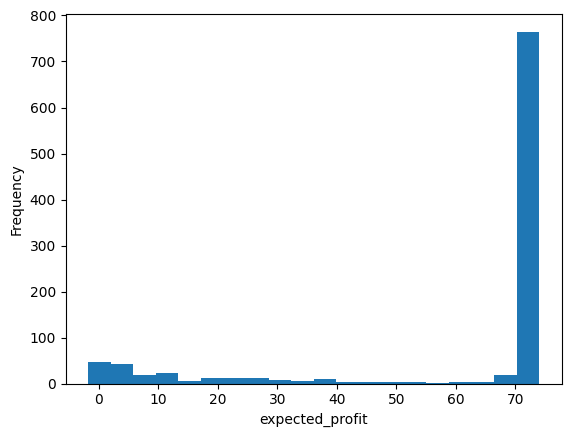

In [11]:
# evaluate effectiveness of randomized selection
random_sample = random_feasible_sample_generator(n_total)
E_profit_rand = pd.Series([E_profit.loc[ind,dow] for ind, dow in random_sample.items()]) # extract expected profit from each selected customer on the assigned call day
random_sample_profit = E_profit_rand.sum()
print(f'The expected profit from all calls is £{random_sample_profit:,.2f}')
ax = E_profit_rand.plot.hist(bins=20)
_ = ax.set_xlabel('expected_profit')

The total profit intuitively feels positive. It should be noted that some of the expected profits are negative. This is correct as some devices may have had a positive expected profit on their optimal day (met criteria for call consideration) but were randomly assigned to a non-optimum day.

## Optimised solution
Optimise the selection of customers and call days to maximise expected profit.

Whilst there are many optimisation algorithms available. The specific formulation of this problem considerably constrains the available choices:
- Local optimisers cannot be used as they are primarily for continuous functions, especially those utilising gradients. Additionally, there is no expectation that the fitness function would be convex.
- MILP cannot be used because the objective function is not linear
- Global optimiser that are designed for continuous functions are also excluded as the problem is represented using integers

Due to these restrictions, the Genetic Algorithm is selected for the optimisation.

In [12]:
# define optimisation parameters
n_opt = X_supp['potent_profit'].value_counts()[True] # number of customers to optimise for.
n_pop = 100 # size of population
CXPB, MUTPB = 0.25, 0.1 # probability of crossing and mutating
day_int_map = {i:k for i,k in enumerate(E_profit.columns)} # create mapping to integer as GA takes integers
int_day_map = {k:i for i,k in day_int_map.items()} # inverse mapping
unselected_ind = [k for k,v in day_int_map.items() if v=='never'][0] # index of unselected customers
max_gen = 5_000 # max number of generations
max_dur = 10*60 # maximum duration of optimisation in seconds
n_early_stop = 500 # maximum number of generation to continue for without seeing improvement

In [13]:
# define optimisation function

# objective function
def obj_fun(individual):

    # extract expected profit for each device on their selected day
    a = np.take_along_axis(E_profit.values, np.array(individual).reshape(-1,1), axis=1)

    return a.sum(),

# constraint magnitude
def distance(individual):

    # reformat individual
    ind = E_profit.loc[[x!=unselected_ind for x in individual]].index
    dow = [x for x in individual if x!=unselected_ind]
    sample = dict(zip(ind, dow))

    # assess magnitude of contraint violation
    daily_limit,total_limit,age_limit,job_limit = constraints_magnitude(sample)
    
    return 200*(daily_limit+total_limit+age_limit+job_limit)

# constraint boolean
def feasible(individual):
    
    return distance(individual)<=0

In [14]:
# initialise GA functions and classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()                      
toolbox.register("attr_day", random.randint, 0, E_profit.shape[1]-1) # define gene as integer for each possible outcome
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_day, n_opt) # define individual as consisting of one gene per customer
toolbox.register("population", tools.initRepeat, list, toolbox.individual) # define the population to be a list of individuals

In [15]:
# registrater operators
toolbox.register("evaluate", obj_fun)
toolbox.decorate("evaluate", tools.DeltaPenalty(feasible, -10_000, distance)) # add constraints penalty
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=E_profit.shape[1]-1, indpb=0.02) # mutation probability, method and bounds
toolbox.register("select", tools.selTournament, tournsize=3) # tournament size for selection

In [16]:
# function to reformat sample to match that of GA individual
def deap_individual_formatter(individual):

    # convert from incorrectly ordered dictionary of selected items to list aligned with dataframe index
    padded_ordered = [individual.get(i) for i in X_test_df.index]

    # convert string/missing days of week to integers
    padded_ordered_numerical = [unselected_ind if i is None else int_day_map[i] for i in padded_ordered]

    return padded_ordered_numerical

In [17]:
# initialise optimisation
gen_summ = pd.DataFrame(columns=['incumbent', 'max', 'min', 'mean'], dtype=float)
population = [creator.Individual(deap_individual_formatter(random_feasible_sample_generator(n_total))) for i in range(n_pop)] # initialise population with feasible individuals
fitnesses = list(map(toolbox.evaluate, population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit
fits = [ind.fitness.values[0] for ind in population] # extracting all the fitnesses
gen_no = 0
incumbent = {'gen':-1, 'score': -np.inf, 'genes': []}

# loop until any of the stopping criteria are met
t_start = time.process_time()
while gen_no < max_gen and (time.process_time()-t_start)<max_dur and (gen_no-incumbent['gen'])<n_early_stop:

    # perform genetic algorithm evolution
    population, fits = utils.ga_evolution(toolbox, population, CXPB, MUTPB)

    # update incumbent
    best_ind = tools.selBest(population, 1)[0]
    if best_ind.fitness.values[0]>incumbent['score']:
        incumbent = {'gen':gen_no, 'score': best_ind.fitness.values[0], 'genes': best_ind}

    # save summary
    gen_summ_new = pd.Series({
        'incumbent': incumbent['score'],
        'max': max(fits),
        'min': min(fits),
        'mean': sum(fits)/len(fits)
    })
    gen_summ_new = gen_summ_new.to_frame(gen_no).transpose()
    gen_summ = pd.concat([gen_summ, gen_summ_new])

    # print update intermittently
    if gen_no % 100 == 0:
        max_val = gen_summ_new.loc[gen_no,'max']
        print(f'Generation {gen_no:4.0f}: £{max_val:,.2f}')

    # iterate counter
    gen_no+=1

# name index of summary table
gen_summ.index.name = 'generation'

Generation    0: £62,819.29
Generation  100: £63,608.87
Generation  200: £63,608.87
Generation  300: £63,608.87
Generation  400: £63,608.87
Generation  500: £63,608.87


,incumbent,max,min,mean
generation,,,,
0,62819.29,62819.29,60093.84,61134.58
200,63683.87,63608.87,-15000.00,55875.98
400,63683.87,63608.87,-15000.00,57374.16


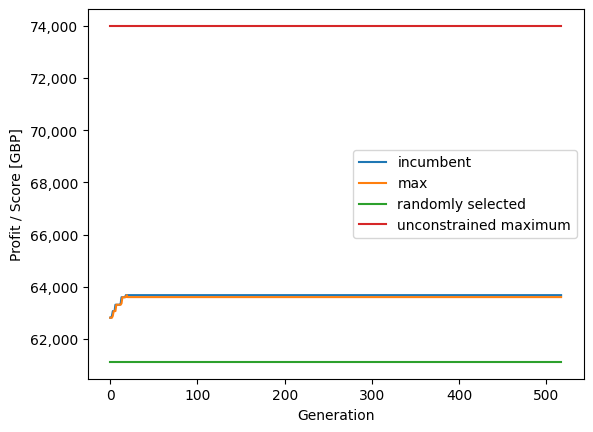

In [18]:
# display subset of summary table

# plot as figure
fig, ax = plt.subplots()
gen_summ.plot(y=['incumbent', 'max'], ax=ax)
ax.plot([gen_summ.index.min(), gen_summ.index.max()], [random_sample_profit, random_sample_profit], label='randomly selected')
theoretical_max = X_supp['max_exp_profit'].sort_values().iloc[-n_total:].sum()
ax.plot([gen_summ.index.min(), gen_summ.index.max()], [theoretical_max, theoretical_max], label='unconstrained maximum')
ax.legend(loc='best')
ax.set_xlabel('Generation')
ax.set_ylabel('Profit / Score [GBP]')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# display values
display(gen_summ.iloc[::200].round(2))

## Investigate optimised solution
Investigate how close the optimised solution is to the constraints and compare its performance to the randomised solution

In [19]:
# add resulting call day decision to dataframe for use by call centre operatives
X_supp['call_day'] = pd.Series(index=E_profit.index, data=incumbent['genes']).map(day_int_map)
X_supp

,max_exp_profit,potent_profit,age_const,job_const,call_day
20628,-1.063495,False,NaN,NaN,NaN
4344,73.336647,True,True,True,thu
20933,-5.979484,False,NaN,NaN,NaN
4641,-1.128650,False,NaN,NaN,NaN
4638,-4.651447,False,NaN,NaN,NaN
...,...,...,...,...,...
14234,73.992699,True,True,True,never
28828,-5.999034,False,NaN,NaN,NaN
1994,73.891884,True,True,True,tue
26655,73.997292,True,False,False,never


In [20]:
# how close to the age consent constraint is the solution
X_supp.loc[X_supp['call_day'].isin(ordinality_dict['day_of_week']),'age_const'].value_counts(normalize=True)

True     0.669
False    0.331
Name: age_const, dtype: float64

In [21]:
# how close to the job consent constraint is the solution
X_supp.loc[X_supp['call_day'].isin(ordinality_dict['day_of_week']),'job_const'].value_counts(normalize=True)

True     0.653
False    0.347
Name: job_const, dtype: float64

In [22]:
# how close to the daily limit constraint is the solution
X_supp['call_day'].value_counts()

never    1325
thu       239
tue       198
fri       198
mon       194
wed       171
Name: call_day, dtype: int64

In [23]:
# how close to the total limit constraint is the solution
X_supp.loc[X_supp['call_day'].isin(ordinality_dict['day_of_week']),'job_const'].count()

1000

In [24]:
gain = obj_fun(incumbent['genes'])[0]/E_profit_rand.sum()
print(f'The optimised call strategy yielded a {(100*gain-100):0.1f}% increase in profit')

The optimised call strategy yielded a 4.2% increase in profit


The solution appears to have 1 of the 4 constraints as active: the limit of 1000 customers. This is not surprising as adding more customers to the call list is likely to be positive until the only remaining customers have poor expected profit values. Considering the only active constraint, the limit of total customers, is accounted for in the theoretical maximum, it should be investigated as to why a value closer to this was not achieved.

## Summary
The model from part one was used to estimate the expected profit for calling each device on each day. The set of customers considered was reduced by excluding devices that were expected to be a loss on any day called. This reduction in considered customers considerably reduces the number of combinations the optimiser must consider. A feasible randomised solution was created to provide a baseline profit of just over ~61.1k GBP. Subsequntly, a genetic algorithm optimisation was used to maximise the profit. The results of this optimisation achieved a profit of ~63.6k GBP, an improvement of over 4.2%. Whilst this is a small improvement, it is worth noting that the day of the week was not considered to be a largely influencial feature which suggests that optimisation over this feature will not be largely impactful.